$High$ $Frequency$ $Trading$ $Strategy$ $Using$ $Machine$ $Learning$

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
                              GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


$load$ $data$

In [3]:
def read_csv(day_trade):
    data_up = []
    data_down = []
    path = '/home/rory/SGX-OrderBook-Tick-Data-Trading-Strategy/Train_Test_Data/ML_data_2014'
    for j,i in enumerate(day_trade):
        for k in range(0,len(i),1):
            path_up = path + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'UP' + '.csv'
            path_down = path + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'DOWN' + '.csv'
            data_up.append(pd.read_csv(path_up))
            data_down.append(pd.read_csv(path_down))
            #print path_down
    return data_up,data_down

In [4]:
day_trade = [[2,3,6,7,8,10,13,14,15,16]]

In [5]:
data_2014_up, data_2014_down = read_csv(day_trade)

$Models$

In [7]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state = 0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state = 0),
    'AdaBoostClassifier': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),\
                                             n_estimators = 10,random_state = 0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 0),
    'SVC': SVC(probability=True,random_state = 0)
}

$Hyperparameter$ $Tuning$

In [10]:
model_grid_params = {
    'RandomForestClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                              'min_samples_split':[2],'criterion':['entropy'],\
                               'min_samples_leaf':[3]},
    'ExtraTreesClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                             'min_samples_split':[2],'criterion':['entropy'],\
                             'min_samples_leaf':[3]},
    'AdaBoostClassifier': {"base_estimator__criterion" : ["entropy"],\
                           "base_estimator__max_depth": [None],\
                           "base_estimator__min_samples_leaf" : [3],\
                           "base_estimator__min_samples_split" : [2],\
                           "base_estimator__max_features" : [None]},
    'GradientBoostingClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                                   'min_samples_split':[2],'min_samples_leaf':[3],\
                                   'learning_rate':[0.1],'subsample':[1.0]},
    'SVC': [{'kernel':['rbf'],'gamma':[1e-1],'C':[1]},\
            {'kernel':['linear'],'C':[1,10]}]
}

$Model$ $Selection$

In [74]:
class Model_Selection:
    
    def __init__(self,models,model_grid_params,data_2014,latest_sec,pred_sec,day):
        
        self.models = models
        self.model_grid = model_grid_params
        self.data_2014 = data_2014
        self.latest_sec = latest_sec
        self.pred_sec = pred_sec
        self.day = day
        self.keys = models.keys()
        self.best_score = {}
        self.grid = {}
        self.predict_values = {}
        self.cv_acc = {}
        self.acc = {}
        self.fscore = {}
        self.true_values = {}
        self.feature_importance = {}
        self.predict_values_day = {}
        self.cv_acc_day = {}
        self.acc_day = {}
        self.fscore_day = {}
        self.true_values_day = {}
        self.feature_importance_day = {}
        self.summary_day = []
        
        
    def Grid_fit(self,X_train,y_train,cv = 5,scoring = 'accuracy'):
        
        for key in self.keys:
            #print "Running GridSearchCV for %s."%(key)
            model = self.models[key]
            model_grid = self.model_grid[key]
            Grid = GridSearchCV(model, model_grid, cv = cv, scoring = scoring)
            Grid.fit(X_train,y_train) 
            self.grid[key] = Grid
            #print Grid.best_params_
            #print 'CV Best Score = %s'%(Grid.best_score_)
            self.cv_acc[key].append(Grid.best_score_)  
    
    def model_fit(self,X_train, y_train, X_test, y_test):
        
        for key in self.keys:
            
            #print "Running training & testing for %s." %(key)
            model = self.models[key]
            model.set_params(**self.grid[key].best_params_)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            #print 'Prediction latest 15 second = %s'%(predictions)
            self.predict_values[key].append(predictions.tolist())
            self.true_values[key].append(y_test.tolist())
            acc = metrics.accuracy_score(y_test,predictions)
            f_score = metrics.f1_score(y_test,predictions)
            #print 'Accuracy = %s'%(acc)
            self.acc[key].append(acc)
            self.fscore[key].append(f_score)
            
            if key == 'SVC':
                if self.grid[key].best_params_.values()[0] == 'linear':
                    feature_imp = dict(zip([i for i in range(0,64,1)],model.coef_[0]))
                    feature_sort = sorted(feature_imp.items(),key = lambda x : x[1], reverse=True)[0:5]
                    feature_top_five = [feature_sort[i][0] for i in range(0,len(feature_sort),1)]
                    #print feature_top_five 
                    self.feature_importance[key].append(feature_top_five)
                    #Top_five = sorted(feature_imp.items(),key = lambda x : x[1], reverse=True)[0:5]
                    #print 'Kernel is linear and top five importance features = %s'%(Top_five)
                else:
                    #print 'Kernel is rbf'
                    pass
            else: 
                feature_imp = dict(zip([i for i in range(0,64,1)],model.feature_importances_))
                feature_sort = sorted(feature_imp.items(),key = lambda x : x[1], reverse=True)[0:5]
                feature_top_five = [feature_sort[i][0] for i in range(0,len(feature_sort),1)]
                self.feature_importance[key].append(feature_top_five)
                #print feature_top_five 
                #print 'Top five importance features = %s'%(Top_five)
                pass

    def pipline(self):
        
        self.set_list_day() # store day values
        for day in range(0,self.day,1):
            self.set_list() # store values
            print 'Day = %s'%(day+1)
            for i in range(0,10800-self.latest_sec-600,self.pred_sec):
                
                #print '--------------------Rolling Window Time = %s--------------------'%(i/self.pred_sec)
                # Train data
                data_train = self.data_2014[day][i:i+self.latest_sec]
                X_train = data_train.drop(['0','65','66','67'],axis=1)
                y_train = data_train['0']

                # Test data
                data_test = self.data_2014[day][i + self.latest_sec:i + self.latest_sec + self.pred_sec]
                X_test = data_test.drop(['0','65','66','67'],axis=1)
                y_test = data_test['0']
                
                #start = time.time()
                if len(unique(y_train)) == 2:
                    try:
                        self.Grid_fit(X_train, y_train, cv = 5, scoring = 'accuracy')
                        self.model_fit(X_train, y_train,X_test,y_test)
                    except ValueError:# as BinomialDeviance requires 2 classes:
                        print ValueError
                        continue
                else:
                    continue
                #end = time.time()
                #print 'Total Time = %s'%(end - start)
                
            for key in self.keys:
                
                self.cv_acc_day[key].append(self.cv_acc[key])
                self.acc_day[key].append(self.acc[key])
                self.fscore_day[key].append(self.fscore[key])
                self.true_values_day[key].append(self.true_values[key])
                self.predict_values_day[key].append(self.predict_values[key])
                self.feature_importance_day[key].append(self.feature_importance[key])
                
            self.summary_day.append(self.score_summary(sort_by = 'Accuracy_mean'))
    
    def set_list(self):
        
        for key in self.keys:
            
            self.predict_values[key] = []
            self.cv_acc[key] = []
            self.acc[key] = []
            self.fscore[key] = []
            self.true_values[key] = []
            self.feature_importance[key] = []
            
    def set_list_day(self):
        
        for key in self.keys:
            
            self.predict_values_day[key] = []
            self.cv_acc_day[key] = []
            self.acc_day[key] = []
            self.fscore_day[key] = []
            self.true_values_day[key] = []
            self.feature_importance_day[key] = []
            
    def score_summary(self,sort_by):
        
        summary = pd.concat([pd.DataFrame(self.acc.keys()),pd.DataFrame(map(lambda x: mean(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: std(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: max(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: min(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: mean(self.fscore[x]), self.fscore))],axis=1)
        summary.columns = ['Estimator','Accuracy_mean','Accuracy_std','Accuracy_max','Accuracy_min','F_score']
        summary.index.rename('Ranking', inplace=True)
        return summary.sort_values(by = [sort_by], ascending=False)
          
    def print_(self):
        print self.predict_values


In [75]:
latest_sec = 60 * 30
pred_sec = 10
day = 10
data_2014_up, data_2014_down = read_csv(day_trade)
data_2014 = data_2014_down
pip = Model_Selection(models,model_grid_params,data_2014,latest_sec,pred_sec,day)

In [76]:
start = time.time()
pip.pipline()
end = time.time()
print 'Total Time = %s'%(end-start)

Day = 1
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
<type 'exceptions.ValueError'>
Day = 2
Day = 3
Day = 4
Day = 5


KeyboardInterrupt: 

In [77]:
pip.summary_day[0]#.reset_index(drop = True)

,Estimator,Accuracy_mean,Accuracy_std,Accuracy_max,Accuracy_min,F_score
Ranking,,,,,,
0,ExtraTreesClassifier,0.957655,0.164631,1.0,0.0,0.233984
1,AdaBoostClassifier,0.953517,0.173020,1.0,0.0,0.234833
4,RandomForestClassifier,0.951586,0.171366,1.0,0.0,0.229791
3,GradientBoostingClassifier,0.927172,0.211186,1.0,0.0,0.215144
2,SVC,0.917379,0.240749,1.0,0.0,0.211940


In [13]:
pip.summary_day[1]#.reset_index(drop = True)

,Estimator,Accuracy_mean,Accuracy_std,Accuracy_max,Accuracy_min,F_score
Ranking,,,,,,
0,ExtraTreesClassifier,0.956071,0.162748,1.0,0.0,0.490869
1,AdaBoostClassifier,0.945595,0.177092,1.0,0.0,0.488133
4,RandomForestClassifier,0.935952,0.190220,1.0,0.0,0.482285
3,GradientBoostingClassifier,0.917381,0.213938,1.0,0.0,0.475873
2,SVC,0.887500,0.268237,1.0,0.0,0.464739


In [14]:
pip.summary_day[2]#.reset_index(drop = True)

,Estimator,Accuracy_mean,Accuracy_std,Accuracy_max,Accuracy_min,F_score
Ranking,,,,,,
0,ExtraTreesClassifier,0.961190,0.150613,1.0,0.0,0.409339
1,AdaBoostClassifier,0.953690,0.158372,1.0,0.0,0.403300
4,RandomForestClassifier,0.947024,0.171452,1.0,0.0,0.400995
3,GradientBoostingClassifier,0.927262,0.202854,1.0,0.0,0.391751
2,SVC,0.893333,0.268467,1.0,0.0,0.364234


In [78]:
pip.summary_day[3]#.reset_index(drop = True)

,Estimator,Accuracy_mean,Accuracy_std,Accuracy_max,Accuracy_min,F_score
Ranking,,,,,,
0,ExtraTreesClassifier,0.975092,0.131935,1.0,0.0,0.256617
4,RandomForestClassifier,0.969420,0.145044,1.0,0.0,0.257600
1,AdaBoostClassifier,0.965475,0.144497,1.0,0.0,0.249010
3,GradientBoostingClassifier,0.962145,0.156676,1.0,0.0,0.252682
2,SVC,0.930210,0.226619,1.0,0.0,0.229166


In [177]:
top1 = []
top2 = []
top3 = []
top4 = []
top5 = []
for day in range(0,4,1):
    for key in pip.keys:
        feature_key = pip.feature_importance_day[key][day]
        #print len(feature_key)
        top1_imp = [feature_key[i][0] for i in range(0,len(feature_key),1)]
        top2_imp = [feature_key[i][1] for i in range(0,len(feature_key),1)]
        top3_imp = [feature_key[i][2] for i in range(0,len(feature_key),1)]
        top4_imp = [feature_key[i][3] for i in range(0,len(feature_key),1)]
        top5_imp = [feature_key[i][4] for i in range(0,len(feature_key),1)]
        top1.append(top1_imp)
        top2.append(top2_imp)
        top3.append(top3_imp)
        top4.append(top4_imp)
        top5.append(top5_imp)

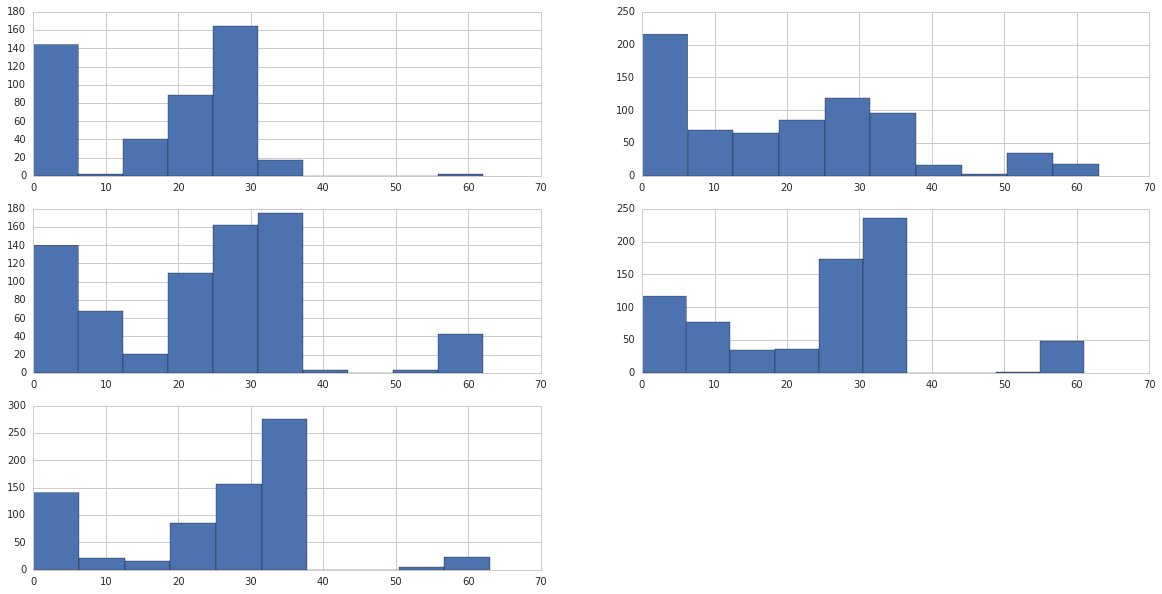

In [207]:
plt.figure(figsize = (20,10))
for i in range(0,5,1):
    plt.subplot(3,2,i+1)
    hist(top1[i])

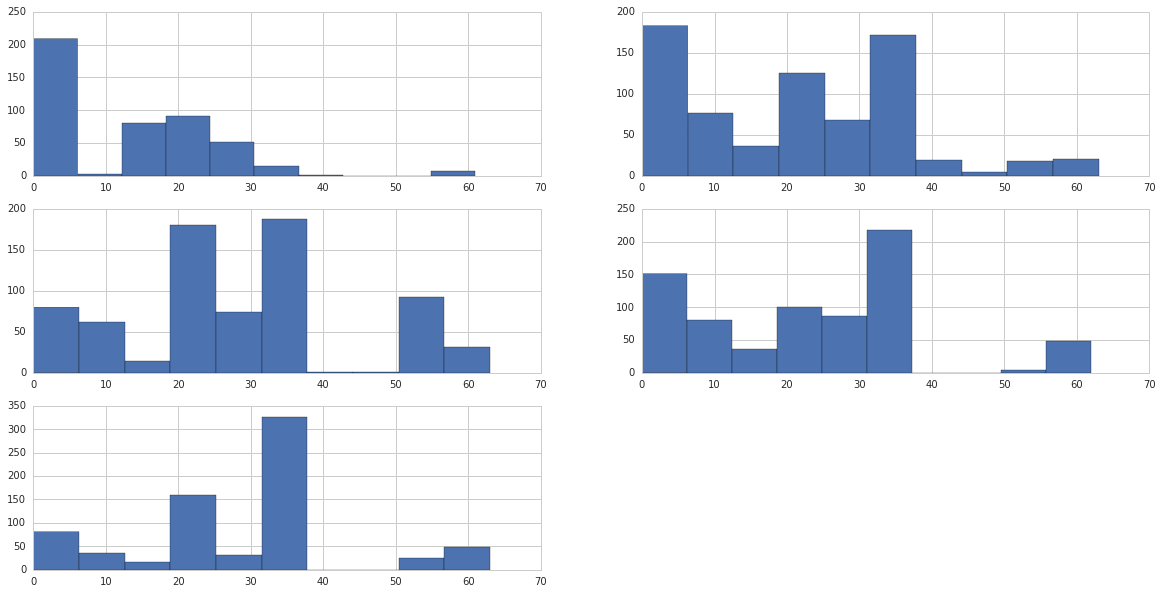

In [206]:
plt.figure(figsize = (20,10))
for i in range(0,5,1):
    plt.subplot(3,2,i+1)
    hist(top2[i])

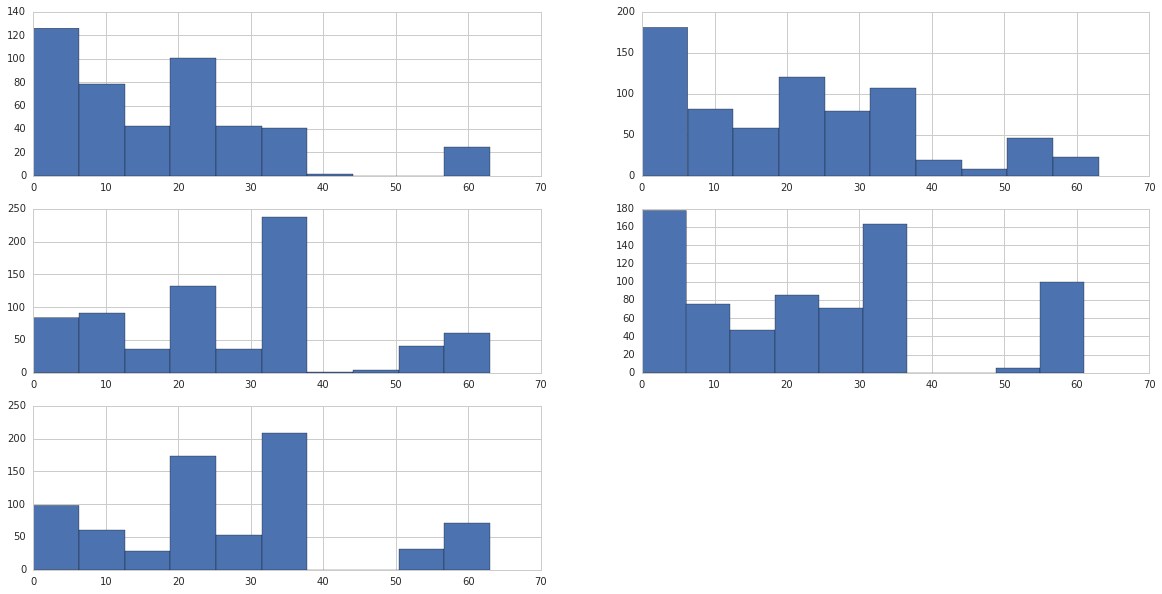

In [205]:
plt.figure(figsize = (20,10))
for i in range(0,5,1):
    plt.subplot(3,2,i+1)
    hist(top3[i])

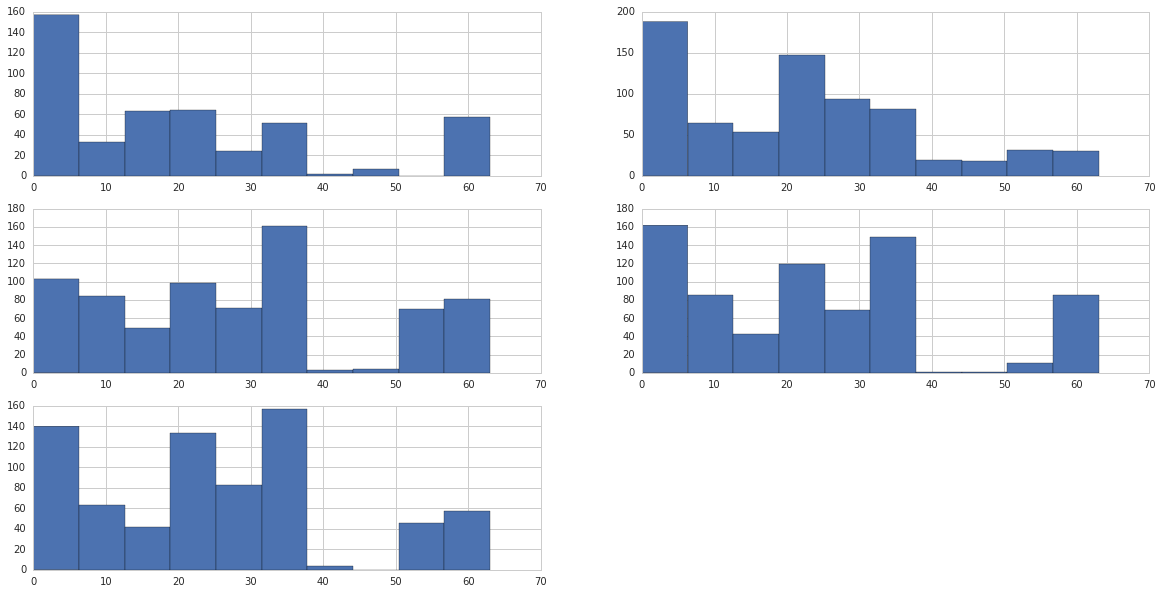

In [204]:
plt.figure(figsize = (20,10))
for i in range(0,5,1):
    plt.subplot(3,2,i+1)
    hist(top4[i])

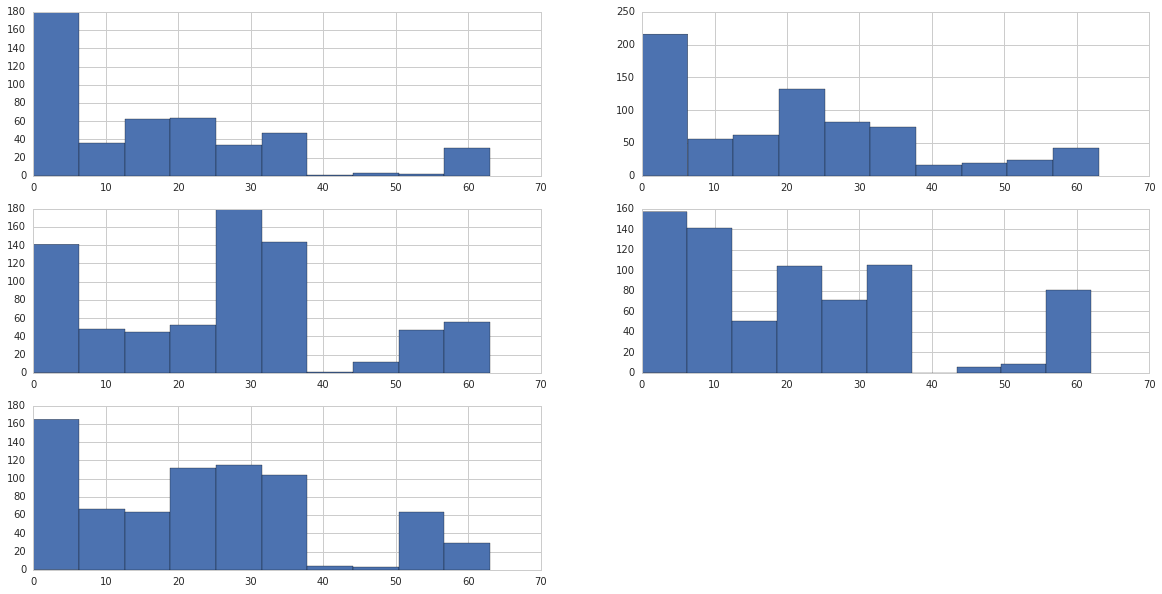

In [203]:
plt.figure(figsize = (20,10))
for i in range(0,5,1):
    plt.subplot(3,2,i+1)
    hist(top5[i])

In [ ]:
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[0],'-o',label = key,lw = 1,markersize = 5)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)

In [137]:
import seaborn as sns

(-0.5, 1.5)

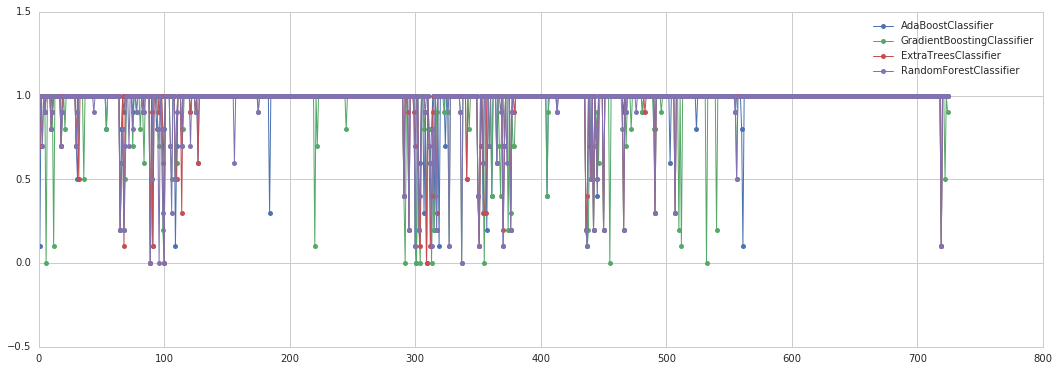

In [182]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color = []
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[0],'-o',label = key,lw = 1,markersize = 5)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)

(-0.5, 1.5)

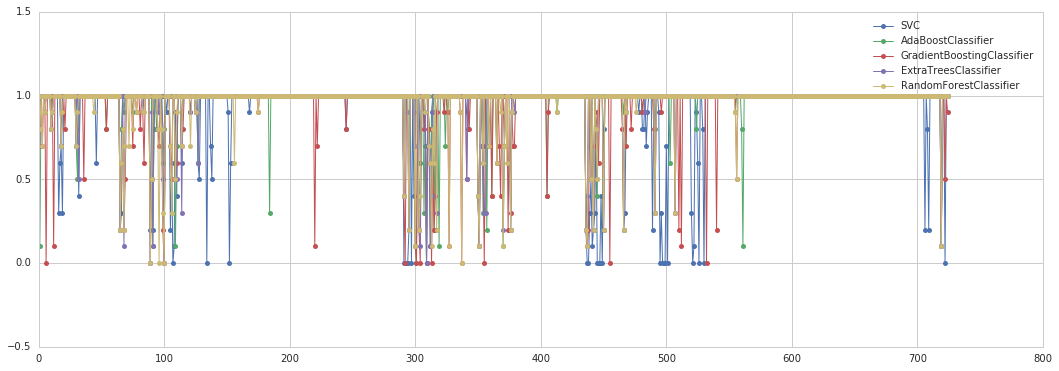

In [138]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color = []
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[0],'-o',label = key,lw = 1,markersize = 5)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)

(-0.5, 1.5)

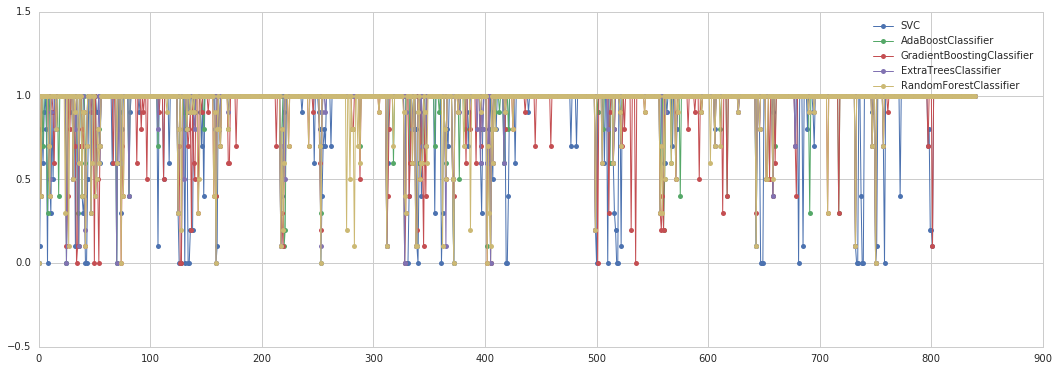

In [139]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color = []
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[1],'-o',label = key,lw = 1,markersize = 5)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)

(-0.5, 1.5)

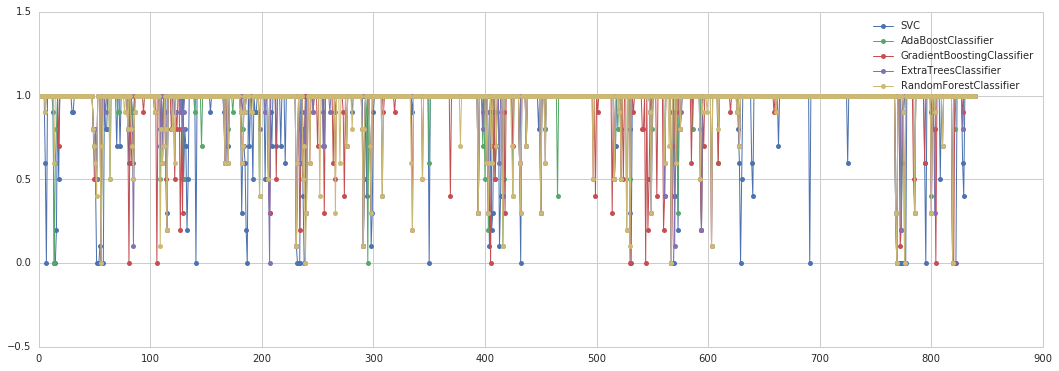

In [140]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color = []
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[2],'-o',label = key,lw = 1,markersize = 5)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)

(-0.5, 1.5)

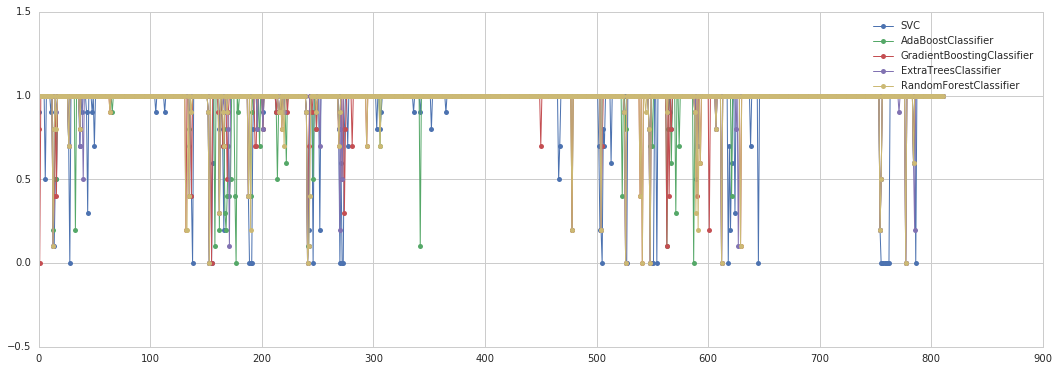

In [141]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color = []
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[3],'-o',label = key,lw = 1,markersize = 5)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)

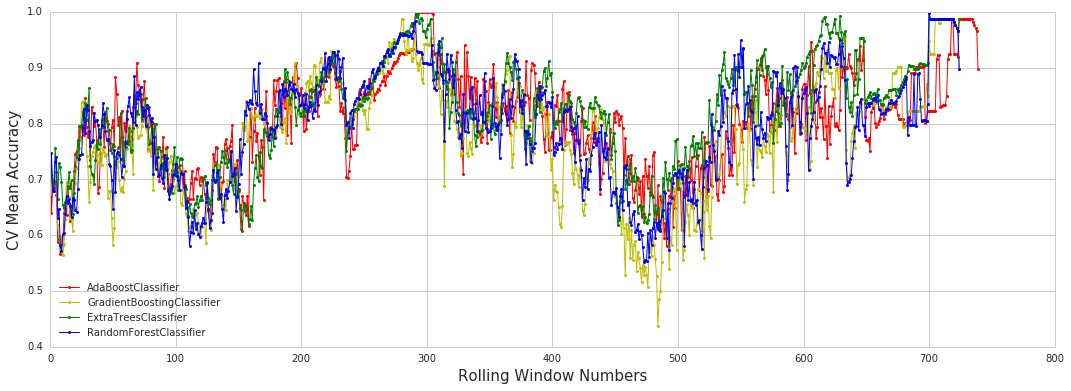

In [184]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color_ = ['r','y','g','b']
for index,key in enumerate(pip.keys):
    plot(np.array(pip.cv_acc_day[key])[0],'-o',label = key,color = color_[index],lw = 1,markersize = 3)
#plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

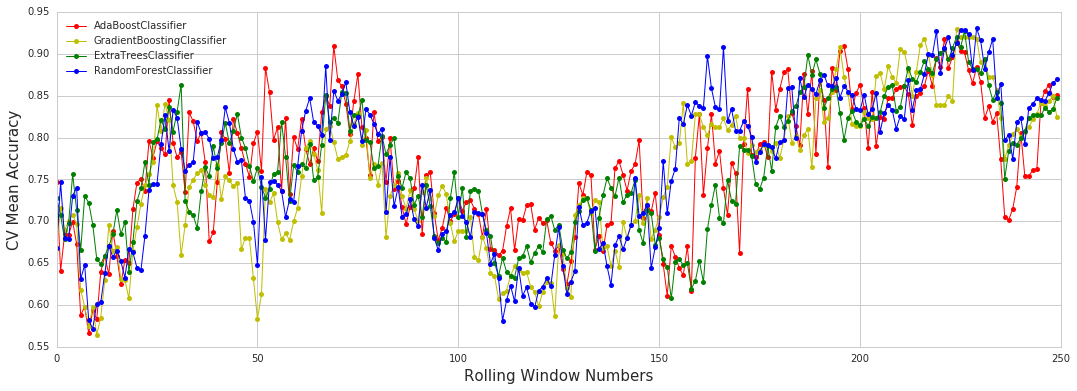

In [186]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color_ = ['r','y','g','b']
for index,key in enumerate(pip.keys):
    plot(np.array(pip.cv_acc_day[key])[0][0:250],'-o',label = key,color = color_[index],lw = 1,markersize = 5)
#plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

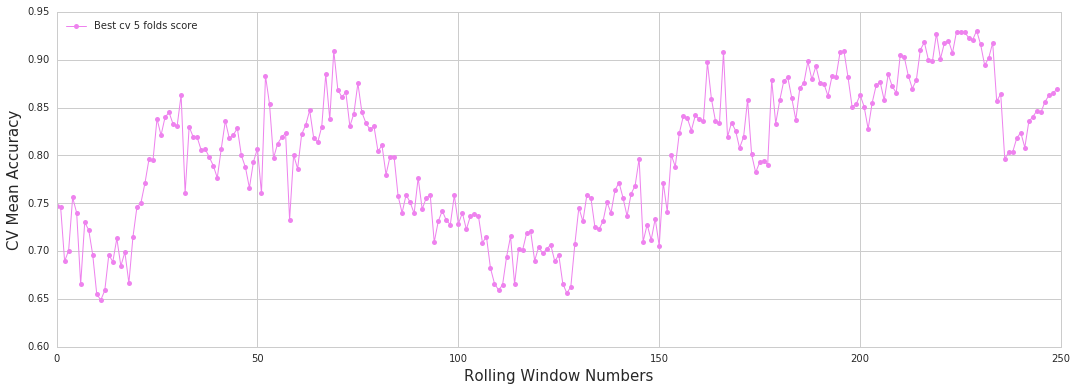

In [187]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
plot(best_cv_score[0:250],'-o',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

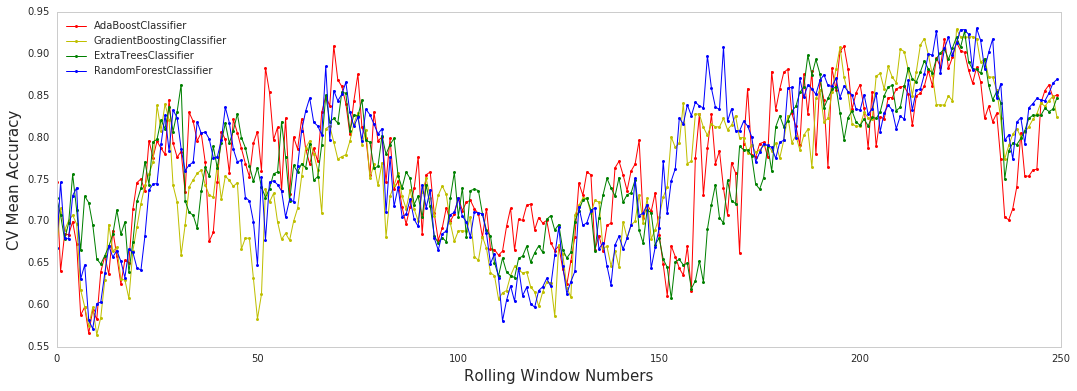

In [189]:
plt.figure(figsize = (18,6))
color_ = ['r','y','g','b']
for index,key in enumerate(pip.keys):
    plot(np.array(pip.cv_acc_day[key])[0][0:250],'-o',label = key,color = color_[index],lw = 1,markersize = 3)
#plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc=0)
plt.grid()
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

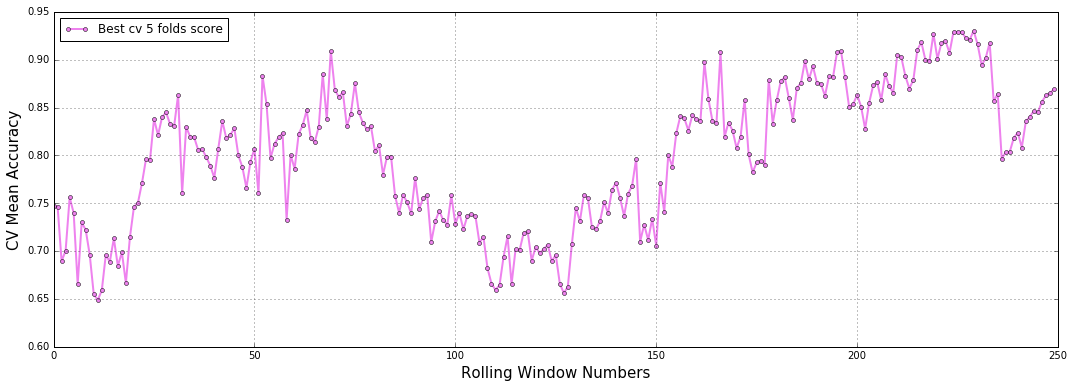

In [179]:
plt.figure(figsize = (18,6))
plot(best_cv_score[0:250],'-o',label = 'Best cv 5 folds score',color = 'violet',lw = 2,markersize = 4)
plt.legend(loc=0)
plt.grid()
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

In [172]:
# compute cum_profit and Best_cv_score
dict_ = {}
dict_['cum_profit'] = []
dict_['Best_cv_score'] = []

for day in range(0,1,1):
    cum_profit_label = []
    cum_profit = []
    best_cv_score = []
    spread = 0.2 * data_2014[day]['65'][1800:][9::10].values
    loss = 0.2*(data_2014[day]['67'][1800:10800-600][9::10].values - data_2014[day]['67'][1800+600:10800][9::10].values)
    for j in range(0,len(np.array(pip.cv_acc_day[pip.keys[day]])[0]),1):
        max_al = {}
        for i in range(0,len(pip.keys),1):
            max_al[pip.keys[i]] = np.array(pip.cv_acc_day[pip.keys[i]])[day][j]
        # select best algorithm in cv = 5    
        top_cv_acc = sorted(max_al.items(),key = lambda x : x[1], reverse = True)[0:1][0]
        best_cv_score.append(top_cv_acc[1])
        submission = pip.predict_values_day[top_cv_acc[0]][day][j][-1]
        true_value = pip.true_values_day[top_cv_acc[0]][day][j][-1]

        if submission == true_value:
            if submission == 1:
                cum_profit_label.append(1)
                cum_profit.append(spread[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
        elif submission != true_value:
            if submission == 1:
                cum_profit_label.append(-1)
                cum_profit.append(loss[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
                
    dict_['cum_profit'].append(cum_profit)
    dict_['Best_cv_score'].append(best_cv_score)

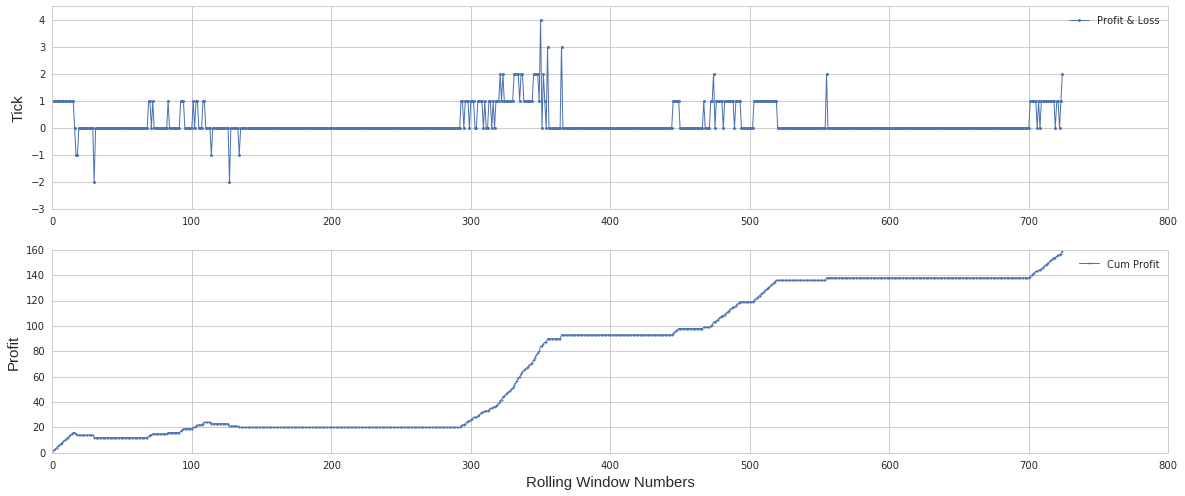

In [173]:
sns.set_style("whitegrid")
plt.figure(figsize = (20,8))
plt.subplot(211)
plot(cum_profit,'-o',label = 'Profit & Loss',lw = 1,markersize = 3)
plt.ylabel('Tick',size = 15)
plt.legend(loc=0)
plt.ylim(-3,4.5)
plt.subplot(212)
plot(cumsum(cum_profit),'-o',label = 'Cum Profit',lw = 1,markersize = 2)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Profit',size = 15)

In [170]:
# compute cum_profit and Best_cv_score
dict_ = {}
dict_['cum_profit'] = []
dict_['Best_cv_score'] = []

for day in range(1,2,1):
    cum_profit_label = []
    cum_profit = []
    best_cv_score = []
    spread = 0.2 * data_2014[day]['65'][1800:][9::10].values
    loss = 0.2*(data_2014[day]['67'][1800:10800-600][9::10].values - data_2014[day]['67'][1800+600:10800][9::10].values)
    for j in range(0,len(np.array(pip.cv_acc_day[pip.keys[day]])[0]),1):
        max_al = {}
        for i in range(0,len(pip.keys),1):
            max_al[pip.keys[i]] = np.array(pip.cv_acc_day[pip.keys[i]])[day][j]
        # select best algorithm in cv = 5    
        top_cv_acc = sorted(max_al.items(),key = lambda x : x[1], reverse = True)[0:1][0]
        best_cv_score.append(top_cv_acc[1])
        submission = pip.predict_values_day[top_cv_acc[0]][day][j][-1]
        true_value = pip.true_values_day[top_cv_acc[0]][day][j][-1]

        if submission == true_value:
            if submission == 1:
                cum_profit_label.append(1)
                cum_profit.append(spread[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
        elif submission != true_value:
            if submission == 1:
                cum_profit_label.append(-1)
                cum_profit.append(loss[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
                
    dict_['cum_profit'].append(cum_profit)
    dict_['Best_cv_score'].append(best_cv_score)

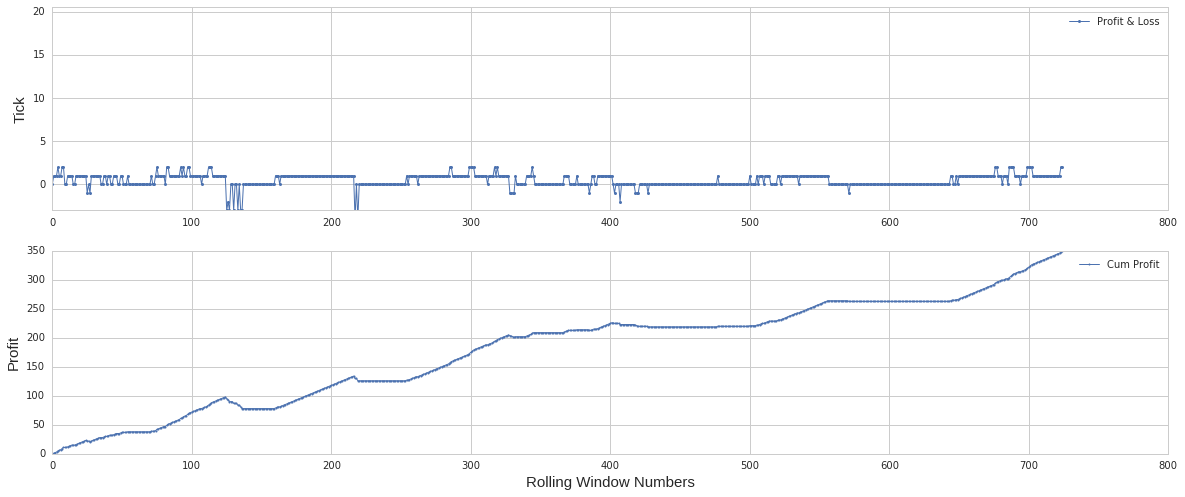

In [171]:
sns.set_style("whitegrid")
plt.figure(figsize = (20,8))
plt.subplot(211)
plot(cum_profit,'-o',label = 'Profit & Loss',lw = 1,markersize = 3)
plt.ylabel('Tick',size = 15)
plt.legend(loc=0)
plt.ylim(-3,20.5)
plt.subplot(212)
plot(cumsum(cum_profit),'-o',label = 'Cum Profit',lw = 1,markersize = 2)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Profit',size = 15)

In [168]:
# compute cum_profit and Best_cv_score
dict_ = {}
dict_['cum_profit'] = []
dict_['Best_cv_score'] = []

for day in range(2,3,1):
    cum_profit_label = []
    cum_profit = []
    best_cv_score = []
    spread = 0.2 * data_2014[day]['65'][1800:][9::10].values
    loss = 0.2*(data_2014[day]['67'][1800:10800-600][9::10].values - data_2014[day]['67'][1800+600:10800][9::10].values)
    for j in range(0,len(np.array(pip.cv_acc_day[pip.keys[day]])[0]),1):
        max_al = {}
        for i in range(0,len(pip.keys),1):
            max_al[pip.keys[i]] = np.array(pip.cv_acc_day[pip.keys[i]])[day][j]
        # select best algorithm in cv = 5    
        top_cv_acc = sorted(max_al.items(),key = lambda x : x[1], reverse = True)[0:1][0]
        best_cv_score.append(top_cv_acc[1])
        submission = pip.predict_values_day[top_cv_acc[0]][day][j][-1]
        true_value = pip.true_values_day[top_cv_acc[0]][day][j][-1]

        if submission == true_value:
            if submission == 1:
                cum_profit_label.append(1)
                cum_profit.append(spread[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
        elif submission != true_value:
            if submission == 1:
                cum_profit_label.append(-1)
                cum_profit.append(loss[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
                
    dict_['cum_profit'].append(cum_profit)
    dict_['Best_cv_score'].append(best_cv_score)

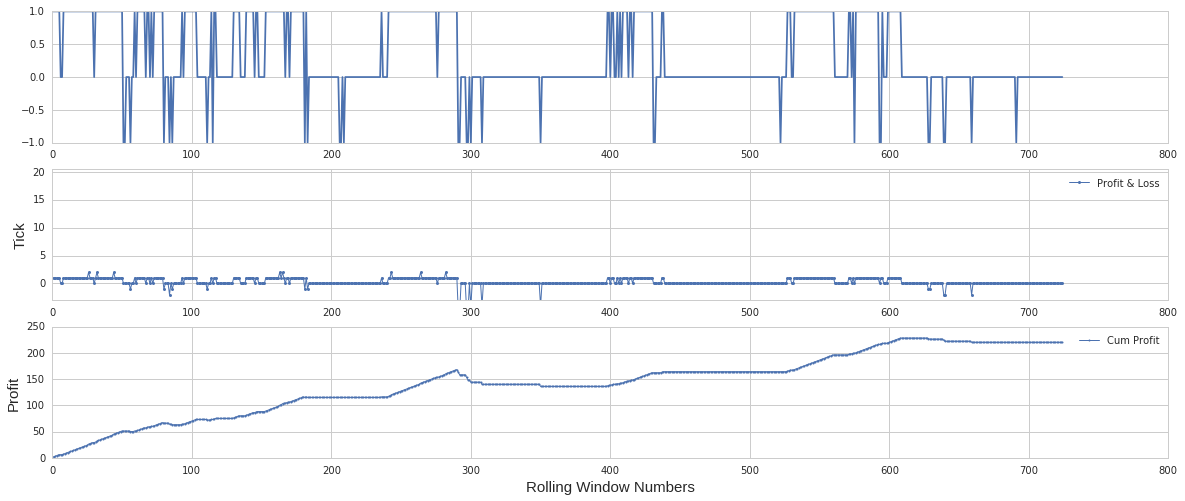

In [169]:
sns.set_style("whitegrid")
plt.figure(figsize = (20,8))
plt.subplot(311)
plot(cum_profit_label)
plt.subplot(312)
plot(cum_profit,'-o',label = 'Profit & Loss',lw = 1,markersize = 3)
plt.ylabel('Tick',size = 15)
plt.legend(loc=0)
plt.ylim(-3,20.5)
plt.subplot(313)
plot(cumsum(cum_profit),'-o',label = 'Cum Profit',lw = 1,markersize = 2)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Profit',size = 15)

In [174]:
# compute cum_profit and Best_cv_score
dict_ = {}
dict_['cum_profit'] = []
dict_['Best_cv_score'] = []

for day in range(3,4,1):
    cum_profit_label = []
    cum_profit = []
    best_cv_score = []
    spread = 0.2 * data_2014[day]['65'][1800:][9::10].values
    loss = 0.2*(data_2014[day]['67'][1800:10800-600][9::10].values - data_2014[day]['67'][1800+600:10800][9::10].values)
    for j in range(0,len(np.array(pip.cv_acc_day[pip.keys[day]])[0]),1):
        max_al = {}
        for i in range(0,len(pip.keys),1):
            max_al[pip.keys[i]] = np.array(pip.cv_acc_day[pip.keys[i]])[day][j]
        # select best algorithm in cv = 5    
        top_cv_acc = sorted(max_al.items(),key = lambda x : x[1], reverse = True)[0:1][0]
        best_cv_score.append(top_cv_acc[1])
        submission = pip.predict_values_day[top_cv_acc[0]][day][j][-1]
        true_value = pip.true_values_day[top_cv_acc[0]][day][j][-1]

        if submission == true_value:
            if submission == 1:
                cum_profit_label.append(1)
                cum_profit.append(spread[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
        elif submission != true_value:
            if submission == 1:
                cum_profit_label.append(-1)
                cum_profit.append(loss[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
                
    dict_['cum_profit'].append(cum_profit)
    dict_['Best_cv_score'].append(best_cv_score)

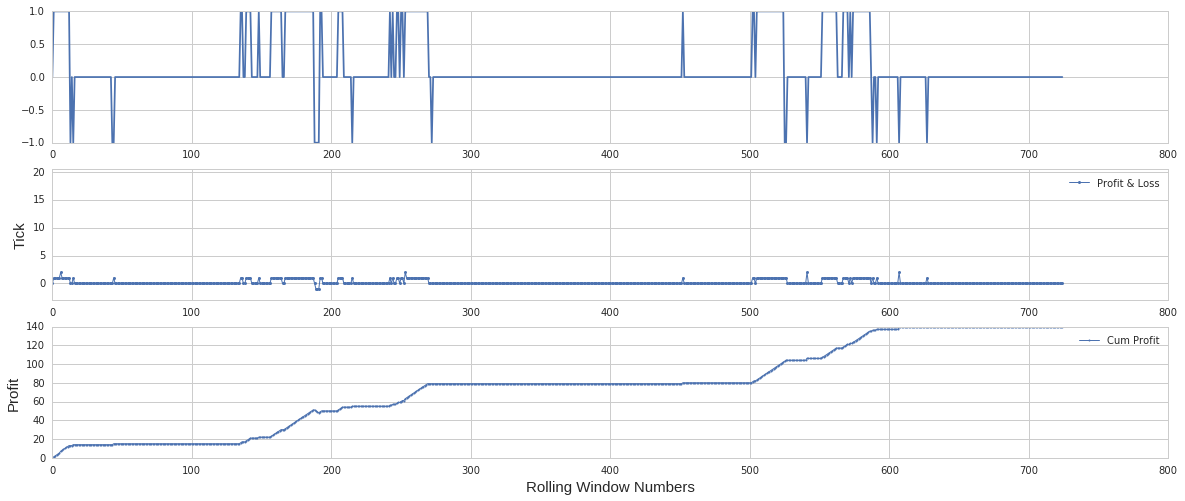

In [175]:
sns.set_style("whitegrid")
plt.figure(figsize = (20,8))
plt.subplot(311)
plot(cum_profit_label)
plt.subplot(312)
plot(cum_profit,'-o',label = 'Profit & Loss',lw = 1,markersize = 3)
plt.ylabel('Tick',size = 15)
plt.legend(loc=0)
plt.ylim(-3,20.5)
plt.subplot(313)
plot(cumsum(cum_profit),'-o',label = 'Cum Profit',lw = 1,markersize = 2)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Profit',size = 15)